.. _nb_callback:

## Callback

A `Callback` class can be used to receive a notification of the algorithm object each generation.
This can be useful to track metrics, do additional calculations, or even modify the algorithm object during the run.
The latter is only recommended for experienced users.

For instance, to keep track of the best solution in each generation:

n_gen |  n_eval |     fopt     |     favg    
    1 |     100 |  0.387099336 |  0.831497479
    2 |     200 |  0.302189349 |  0.578035582
    3 |     300 |  0.267733594 |  0.443801185
    4 |     400 |  0.188215259 |  0.347200983
    5 |     500 |  0.083479177 |  0.272644726
    6 |     600 |  0.083479177 |  0.212567874
    7 |     700 |  0.072492126 |  0.173574163
    8 |     800 |  0.051256476 |  0.140740462
    9 |     900 |  0.041778020 |  0.110370322
   10 |    1000 |  0.041778020 |  0.089125798
   11 |    1100 |  0.031644566 |  0.071339910
   12 |    1200 |  0.030055810 |  0.057941249
   13 |    1300 |  0.021855327 |  0.047786695
   14 |    1400 |  0.017620999 |  0.040676540
   15 |    1500 |  0.014756395 |  0.034902705
   16 |    1600 |  0.014756395 |  0.029778240
   17 |    1700 |  0.012976416 |  0.026185115
   18 |    1800 |  0.008637920 |  0.022664820
   19 |    1900 |  0.006399439 |  0.019648350
   20 |    2000 |  0.006399439 |  0.016725603


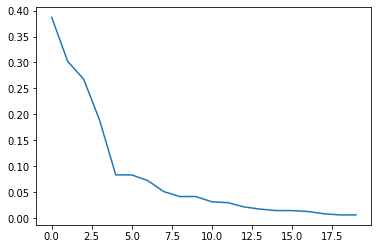

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_problem
from pymoo.model.callback import Callback
from pymoo.optimize import minimize


class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())


problem = get_problem("sphere")

algorithm = GA(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               callback=MyCallback(),
               save_history=True,
               verbose=True)

val = res.algorithm.callback.data["best"]
plt.plot(np.arange(len(val)), val)
plt.show()



If the run's analysis should be done during post-processing, the option `save_history` can be used as well. If a callback is used, history does not need to be saved.
With the `history` object, the same as above can be achieved by using the stored information during the run:

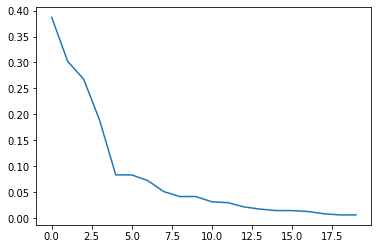

In [4]:
val = [e.pop.get("F").min() for e in res.history]
plt.plot(np.arange(len(val)), val)
plt.show()

If the `save_history` is set true, a deep copy of the algorithm object takes place in each generation. Please note that this can be quite expensive and might not be desired for all runs. However, it provides excellent post-processing options because all data can be accessed, respectively.

## Callback that modifies the algorithm

A very important feature for callack is to modify the algorithm at runtime. For example, a technique used in problems involving genetic algorithms is to explore a lot at first (which means mutation with a high rate) and then simply to improve individuals in a deterministic way (use only the crossover operator)

To do this we implement a custom class ``StopMutationAfterNgenCallaback`` that stop the mutation operator after a number of generation

In [5]:
from pymoo.operators.mutation.no_mutation import NoMutation

class StopMutationAfterNgenCallaback:

    def __init__(self, after_gen: int):
        self.after_gen = after_gen

    def __call__(self, algorithm):

        if algorithm.n_gen == self.after_gen:
            algorithm.mating.mutation = NoMutation()
            # Stop the mutation operator
            algorithm.callback = None
            # After stopping mutation operator this callback is useless, so we stop it
            print("No mutation anymore!")


In [6]:
algorithm = GA(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               callback=StopMutationAfterNgenCallaback(after_gen = 10),
               save_history=True,
               verbose=True)

assert isinstance(res.algorithm.mating.mutation, NoMutation)

n_gen |  n_eval |     fopt     |     favg    
    1 |     100 |  0.387099336 |  0.831497479
    2 |     200 |  0.302189349 |  0.578035582
    3 |     300 |  0.267733594 |  0.443801185
    4 |     400 |  0.188215259 |  0.347200983
    5 |     500 |  0.083479177 |  0.272644726
    6 |     600 |  0.083479177 |  0.212567874
    7 |     700 |  0.072492126 |  0.173574163
    8 |     800 |  0.051256476 |  0.140740462
    9 |     900 |  0.041778020 |  0.110370322
   10 |    1000 |  0.041778020 |  0.089125798
No mutation anymore!
   11 |    1100 |  0.031644566 |  0.067703807
   12 |    1200 |  0.025634427 |  0.050892023
   13 |    1300 |  0.018530875 |  0.038991673
   14 |    1400 |  0.015780620 |  0.030549532
   15 |    1500 |  0.015780620 |  0.025176166
   16 |    1600 |  0.011922145 |  0.020670936
   17 |    1700 |  0.009995114 |  0.017006136
   18 |    1800 |  0.002863949 |  0.013573917
   19 |    1900 |  0.002816449 |  0.010706763
   20 |    2000 |  0.001792894 |  0.008355458


the objective function seems to decrease faster after the tenth generation, compared to the previous run